# Simulations & Experiments for IXO's Pilot Project with Chimple Learning 

[Chimple Learning](http://www.chimple.org/) is a non-profit educational organization dedicated to improving children's learning experience to be fun yet effective through gamification. The [IXO Foundation](https://ixo.world/) has partnered with Chimple to fund educational projects using the [alpha-bond](https://www.alphabond.org/) mechanism. 

In this notebook, we have modified the generic alpha-bond mechanism produced in this R&D collaboration to match the ixo use case, by removing the alpha parameter update via the prediction market attestation mechanism and replacing it with a generated alpha parameter that is responsive to simulated claims by chimple education devices reporting children's test scores in comparison with outcomes benchmarks. 

The diagram below was provided by the ixo Foundation, and roughly maps out the intentions of the pilot being studied in this notebook. The purpose of this simulation is to run the below scenario, and validate that the expected outcome roughly matches the predicted outcome by the simulation.

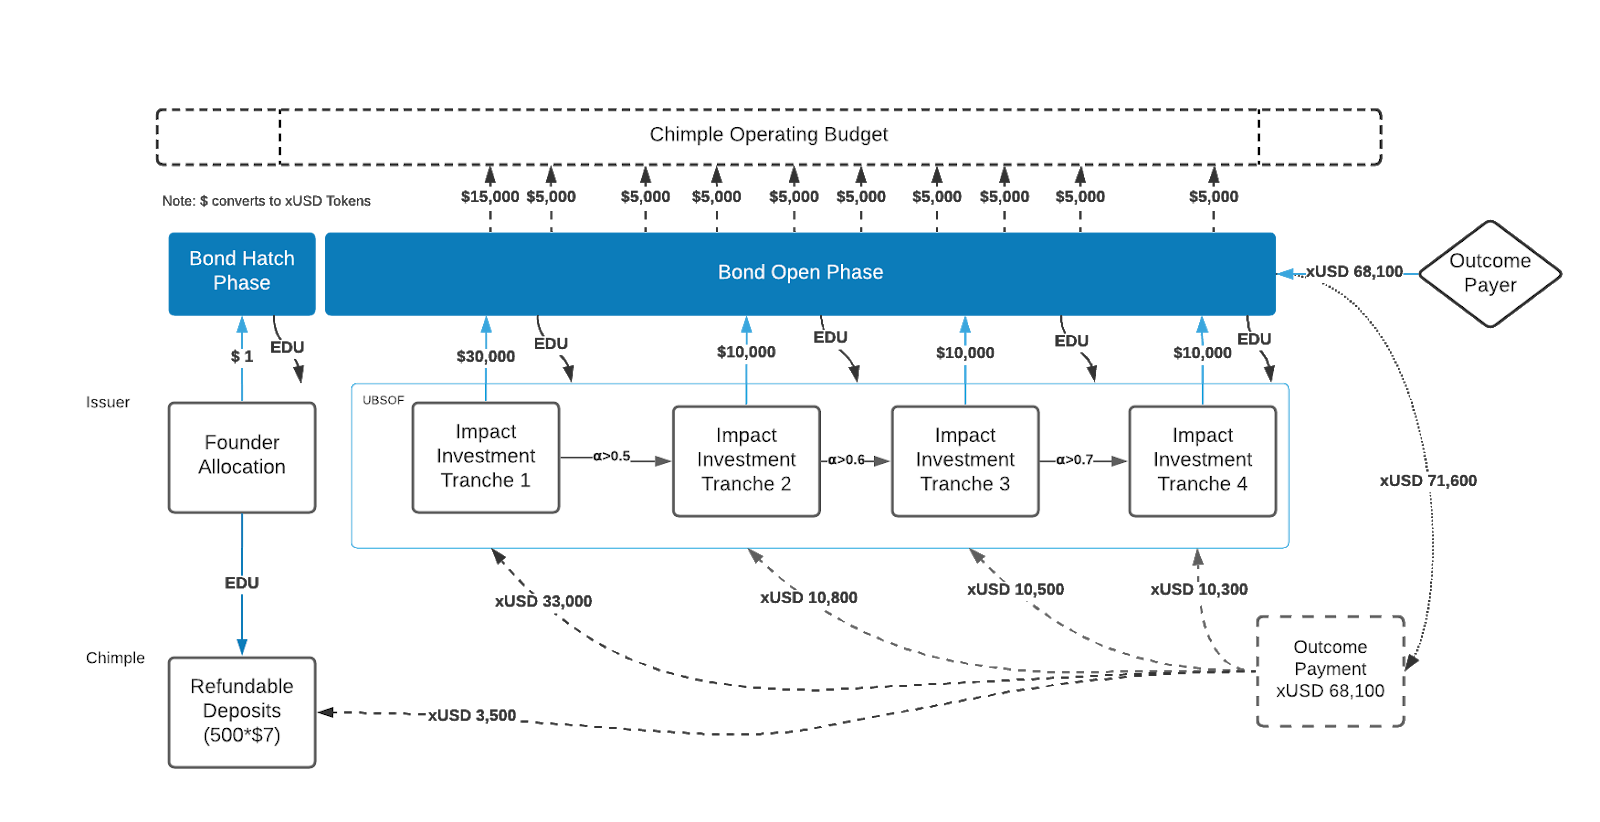

In [1]:
# For displaying image files
from IPython.display import Image
Image("images/Chimple_Scenario-4.png")

## Setup

- Continuous funding is enabled, meaning that the project will get continually funded throughout the execution phase. <br/>
- Burn on the primary bonding curve is disabled. Agents can only bond and cannot burn on the bonding curve. <br/>
- Theta is set to 0, such that 100% of initial funds raised are allocated to project operating funds. 0% of the initial funds go towards the bonding curve reserve. <br/>

Update [sys_params.py](src/sim/model/sys_params.py) to reflect the values below:

- ENABLE_CONTINUOUS = [True] <br/>
- ENABLE_BURN = [False] <br/>
- THETA = [0] 

Alpha belief and Price belief is set to be linearly increasing. <br/>
Update line 44 and 45 in [sys_params.py](src/sim/model/sys_params.py) to reflect the values below: 

- alpha_bias = [1]
- price_bias = [1]


Burning tokens on the bonding curve is not allowed. Participants in the bonding curve will only be able to bond to acquire supply tokens. They will not be able to burn or sell their supply tokens on the primary market, i.e the bonding curve. <br/>

### The specific simulation of the model is as follows:

* 4 agents
* agent reserve 0 (represents tranche 1) = 30000
* agent reserve 1 (represents tranche 2) = 10000
* agent reserve 2 (represents tranche 3) = 10000
* agent reserve 3 (represents tranche 4) = 10000

* C (Outcome payment): 68000 [xUSD]
* reserve: 1 [USD]

The funding flows of the system have been setup as shown in the diagram above. The agents in this simulation are all played by the same outcomes purchaser, with staggered tranches to demonstrate the differing returns for investors that participate earlier vs later in an Alpha Bond lifecycle.


In [2]:
import sys
sys.executable

'C:\\Users\\mbarl\\AppData\\Local\\Continuum\\anaconda3\\pythonw.exe'

In [3]:
pip freeze | grep cadCAD

cadCAD==0.4.23
Note: you may need to restart the kernel to use updated packages.


### Import Libraries for Analysis and Visualization

In [4]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

# For analysis
import numpy as np
import pandas as pd

sns.set_style("whitegrid")

### Import Parent cadCAD Model and Utilities

In [5]:
from cadCAD.configuration import Experiment

from cadCAD import configs

from src.config_wrapper import ConfigWrapper

from src import run_wrapper2
from src import run_wrapper

import src.sim as sim

# custom plotting function
from src.utils import param_test_plot

### Choose number of Monte Carlo runs ('N') and/or number of Timesteps ('T') and/or to update parameter values ('M') 

### Current N, T, and M

In [6]:
# get list of keys and values from M
parametric_experiment = ConfigWrapper(sim)
model_keys = parametric_experiment.get_config()
model_keys[0]

{'N': 1,
 'T': range(0, 365),
 'M': {'starting_kappa': 3,
  'starting_alpha': 0.5,
  'money_raised': 1000000,
  'monthly_instalment': 0,
  'C': 68100,
  'f': 0.03,
  'm': 0.15,
  'beta': 0.9,
  'dust': 1e-08,
  'period': 1200,
  'rules_price': 'martin',
  'E': 0.2,
  'ENABLE_CONTINUOUS': True,
  'THETA': 0,
  'ENABLE_BURN': False,
  'fee_numerator': 997,
  'fee_denominator': 1000,
  'alpha_bias': 1,
  'price_bias': 1,
  'kappa_rule': 'none',
  'alpha_test': 'success',
  'alpha_test_bound': 0.99}}

### Execute cadCAD Simulation

In [7]:
## Choose a parameter values
update_params = {
    # disable selling
    'ENABLE_BURN' : [False],
    'THETA' : [0],
    'C': [68100],
    'alpha_test' : ['success'],
#     'alpha_test' : ['failure'],
}

### Update Timesteps, if desired
Current Number of TImesteps

In [8]:
# Original
New_Timesteps = model_keys[0]['T']

# New Change Value
# New_Timesteps = range(365)
New_Timesteps

range(0, 365)

### Update Monte Carlo Runs, if desired
Current Number of Runs

In [9]:
# Original
New_Runs = model_keys[0]['N']

# New Change Value
# New_Runs = 10
New_Runs

1

In [10]:
parametric_experiment = ConfigWrapper(sim, M=update_params, N=New_Runs, T=New_Timesteps)

### Get Initial Conditions from Config

In [11]:
initial_state = parametric_experiment.get_initial_conditions()
initial_state

{'reserve': 1,
 'pbar': 1,
 'realized_price': 0,
 'spot_price': 1,
 'kappa': 3,
 'supply': 3.0,
 'alpha': 1.468450128716996e-07,
 'alpha_bar': 1.468450128716996e-07,
 'supply_0': 100,
 'supply_1': 1.0,
 'supply_free': -98.0,
 'attestations': 30000,
 'attestations_0': 30000,
 'attestations_1': 100,
 'invariant_V': 27.0,
 'invariant_I': 1.0100001453765628,
 'agents':    id  agent_attestations_1  agent_attestations_0  agent_reserve  \
 0   0                     0                     0          30000   
 1   1                     0                     0          10000   
 2   2                     0                     0          10000   
 3   3                     0                     0          10000   
 
    agent_supply_1  agent_supply_0  agent_supply_free  agent_private_alpha  \
 0               0               0                  0                  0.5   
 1               0               0                  0                  0.5   
 2               0               0                  

#### Choose Number of Agents

In [12]:
number_of_agents = 4

In [13]:
########## AGENT INITIALIZATION ##########
PRIVATE_ALPHA = 0.5
PRIVATE_PRICE = 0.5

r = 0 #1000000  # Agent reserve, the amount of fiat tokens an agent starts with
s = 0
s1 = 0
s0 = 0
s_free = s - (s1+s0)

# Configure agents for agent-based model
agents_df = pd.DataFrame({
    'agent_attestations_1': 0,
    'agent_attestations_0': 0,
    'agent_reserve': r,
    'agent_supply_1': s1,
    'agent_supply_0': s0,
    'agent_supply_free': s_free,
    'agent_private_alpha': PRIVATE_ALPHA,
    'agent_private_price': PRIVATE_PRICE,    
    'agent_private_alpha_signal': 0,
    'agent_private_price_signal': 0,
    'agent_public_alpha_signal': 0,
    'agent_public_price_signal': 0}, index=[0])

agents_df = pd.concat([agents_df]*number_of_agents, ignore_index=True)

# Adding IDs to agents
agents_df.insert(0, 'id', range(0, len(agents_df)))

# vary agent reserves
agents_df['agent_reserve'] = [30000, 10000, 10000, 10000]

# agents_df['agent_reserve'] = 1000000 #[round(num, 2) for num in list(np.random.uniform(1000000,7000000,10))]
agents_df['agent_private_alpha'] = [0.5, 0.5, 0.5, 0.5]
#agents_df['agent_private_alpha'] = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

# vary agent private price
agents_df['agent_private_price'] = [0.5, 0.5, 0.5, 0.5]
#agents_df['agent_private_price'] = 100 # [round(num, 2) for num in list(np.random.uniform(0.4,0.9,10))]



In [14]:
## see initialized values
agents_df[['agent_reserve','agent_private_price']]

,agent_reserve,agent_private_price
0,30000,0.5
1,10000,0.5
2,10000,0.5
3,10000,0.5


### Update Agent into Initial State

In [15]:
initial_state['agents'] = agents_df

### Re-Instantiate Config with Updated Initial Conditions

In [16]:
parametric_experiment = ConfigWrapper(sim, M=update_params, N=New_Runs, T=New_Timesteps)

In [17]:

del configs[:]

parametric_experiment.append()

In [18]:
parametric_experiment.get_config()

[{'N': 1,
  'T': range(0, 365),
  'M': {'starting_kappa': 3,
   'starting_alpha': 0.5,
   'money_raised': 1000000,
   'monthly_instalment': 0,
   'C': 68100,
   'f': 0.03,
   'm': 0.15,
   'beta': 0.9,
   'dust': 1e-08,
   'period': 1200,
   'rules_price': 'martin',
   'E': 0.2,
   'ENABLE_CONTINUOUS': True,
   'THETA': 0,
   'ENABLE_BURN': False,
   'fee_numerator': 997,
   'fee_denominator': 1000,
   'alpha_bias': 1,
   'price_bias': 1,
   'kappa_rule': 'none',
   'alpha_test': 'success',
   'alpha_test_bound': 0.99}}]

### Generate config_ids to match results with swept variable input

In [19]:
def get_M(k, v):
    if k == 'sim_config':
        k, v = 'M', v['M']
    return k, v

config_ids = [
    dict(
        get_M(k, v) for k, v in config.__dict__.items() if k in ['simulation_id', 'run_id', 'sim_config', 'subset_id']
    ) for config in configs
]

### Execute cadCAD Simulation

In [20]:
(data, tensor_field, sessions) = run_wrapper.run(drop_midsteps=False)

experiments = data


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (365, 22, 1, 19)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 1.56s


In [21]:
experiments.head(10)

,index,reserve,pbar,realized_price,spot_price,kappa,supply,alpha,alpha_bar,supply_0,...,invariant_V,invariant_I,agents,chosen_agent,public_alpha,simulation,subset,run,substep,timestep
0,0,1.0000,1.000000,0,1.000000,3.000000,3.000000,1.468450e-07,1.468450e-07,100,...,27.000000,1.010000,id agent_attestations_1 agent_attestation...,0,0,0,0,1,0,0
1,1,1.0000,1.000000,0,1.000000,3.000000,3.000000,1.468450e-07,1.468450e-07,100,...,27.000000,1.010000,id agent_attestations_1 agent_attestation...,"{'id': 0.0, 'agent_attestations_1': 0.0, 'agen...",0,0,0,1,1,1
2,2,1.0000,1.000000,0,1.000000,3.000000,3.000000,1.468450e-07,1.468450e-07,100,...,27.000000,1.010000,id agent_attestations_1 agent_attestation...,"{'id': 0.0, 'agent_attestations_1': 0.0, 'agen...",0,0,0,1,2,1
3,3,30001.0007,332.527842,0,332.527842,3.000000,93.218012,1.468450e-07,1.468450e-07,100,...,27.000000,30001.010700,id agent_attestations_1 agent_attestation...,"{'id': 0.0, 'agent_attestations_1': 0.0, 'agen...",0,0,0,1,3,1
4,4,30001.0007,332.527842,0,332.527842,1.005937,93.218012,2.600146e-03,1.468450e-07,100,...,0.003192,30001.010700,id agent_attestations_1 agent_attestation...,"{'id': 0.0, 'agent_attestations_1': 0.0, 'agen...",0,0,0,1,4,1
5,5,30001.0007,332.527842,0,332.527842,1.005937,93.218012,2.600146e-03,1.468450e-07,100,...,0.003192,30001.010700,id agent_attestations_1 agent_attestatio...,"{'id': 0.0, 'agent_attestations_1': 0.0, 'agen...",0,0,0,1,5,1
6,6,30001.0007,332.527842,0,332.527842,1.005937,93.218012,2.600146e-03,1.468450e-07,100,...,0.003192,30001.010700,id agent_attestations_1 agent_attestatio...,"{'id': 0.0, 'agent_attestations_1': 0.0, 'agen...",0,0,0,1,1,2
7,7,30001.0007,332.527842,0,332.527842,1.005937,93.218012,2.600146e-03,1.468450e-07,100,...,0.003192,30001.010700,id agent_attestations_1 agent_attestatio...,"{'id': 0.0, 'agent_attestations_1': 0.0, 'agen...",0,0,0,1,2,2
8,8,30001.0020,323.747753,0,323.747753,1.005937,93.218016,2.600146e-03,1.468450e-07,100,...,0.003192,30178.071974,id agent_attestations_1 agent_attestatio...,"{'id': 0.0, 'agent_attestations_1': 0.0, 'agen...",0,0,0,1,3,2
9,9,30001.0020,323.747753,0,323.747753,1.023513,93.218016,1.018039e-02,1.468450e-07,100,...,0.003457,30178.071974,id agent_attestations_1 agent_attestatio...,"{'id': 0.0, 'agent_attestations_1': 0.0, 'agen...",0,0,0,1,4,2


In [22]:
experiments.tail()

,index,reserve,pbar,realized_price,spot_price,kappa,supply,alpha,alpha_bar,supply_0,...,invariant_V,invariant_I,agents,chosen_agent,public_alpha,simulation,subset,run,substep,timestep
1821,1821,60001.364,880.381022,0,880.381022,1.955957,133.206523,0.841464,1.468450e-07,100,...,0.238407,117247.566867,id agent_attestations_1 agent_attestatio...,"{'id': 3.0, 'agent_attestations_1': 0.0, 'agen...",0,0,0,1,1,365
1822,1822,60001.364,880.381022,0,880.381022,1.955957,133.206523,0.841464,1.468450e-07,100,...,0.238407,117247.566867,id agent_attestations_1 agent_attestatio...,"{'id': 3.0, 'agent_attestations_1': 0.0, 'agen...",0,0,0,1,2,365
1823,1823,60001.365,881.038611,0,881.038611,1.955957,133.206525,0.841464,1.468450e-07,100,...,0.238407,117305.092992,id agent_attestations_1 agent_attestatio...,"{'id': 3.0, 'agent_attestations_1': 0.0, 'agen...",0,0,0,1,3,365
1824,1824,60001.365,881.038611,0,881.038611,1.956836,133.206525,0.842273,1.468450e-07,100,...,0.239435,117305.092992,id agent_attestations_1 agent_attestatio...,"{'id': 3.0, 'agent_attestations_1': 0.0, 'agen...",0,0,0,1,4,365
1825,1825,60001.365,881.038611,0,881.038611,1.956836,133.206525,0.842273,1.468450e-07,100,...,0.239435,117305.092992,id agent_attestations_1 agent_attestatio...,"{'id': 3.0, 'agent_attestations_1': 0.0, 'agen...",0,0,0,1,5,365


In [23]:
experiments.loc[1825]['agents']

,id,agent_attestations_1,agent_attestations_0,agent_reserve,agent_supply_1,agent_supply_0,agent_supply_free,agent_private_alpha,agent_private_price,agent_private_alpha_signal,agent_private_price_signal,agent_public_alpha_signal,agent_public_price_signal
0,0.0,0.0,0.0,1.000000e-11,0.0,0.0,90.218210,0.590,0.590,0.590,0.590,0.590,0.590
1,1.0,0.0,0.0,1.000000e-11,0.0,0.0,15.759505,0.680,0.680,0.680,0.680,0.680,0.680
2,2.0,0.0,0.0,1.000000e-11,0.0,0.0,12.653473,0.770,0.770,0.770,0.770,0.770,0.770
3,3.0,0.0,0.0,1.000000e-11,0.0,0.0,11.575336,0.865,0.865,0.865,0.865,0.865,0.865


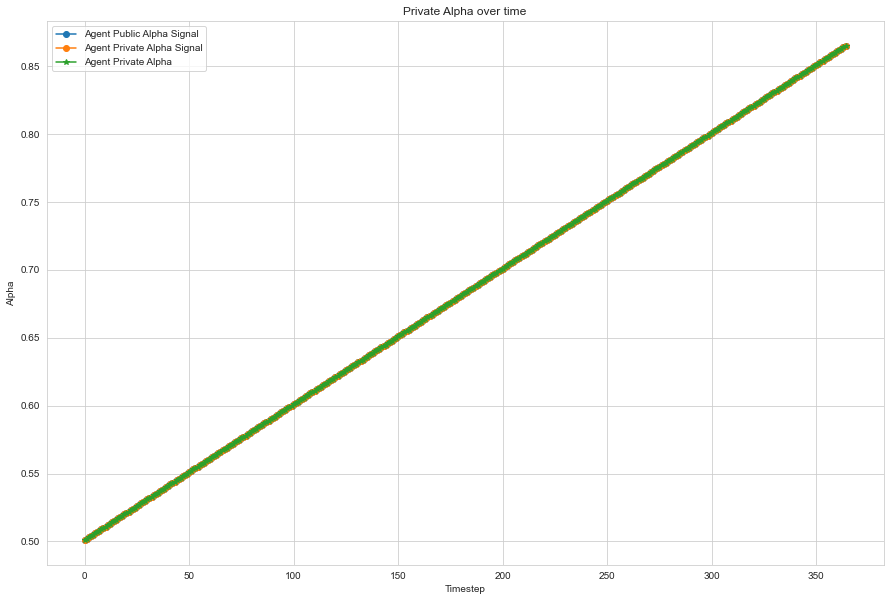

In [24]:
from src.sim.model.parts.utils import *

alpha_plot(experiments,'Private Alpha over time',len(New_Timesteps))

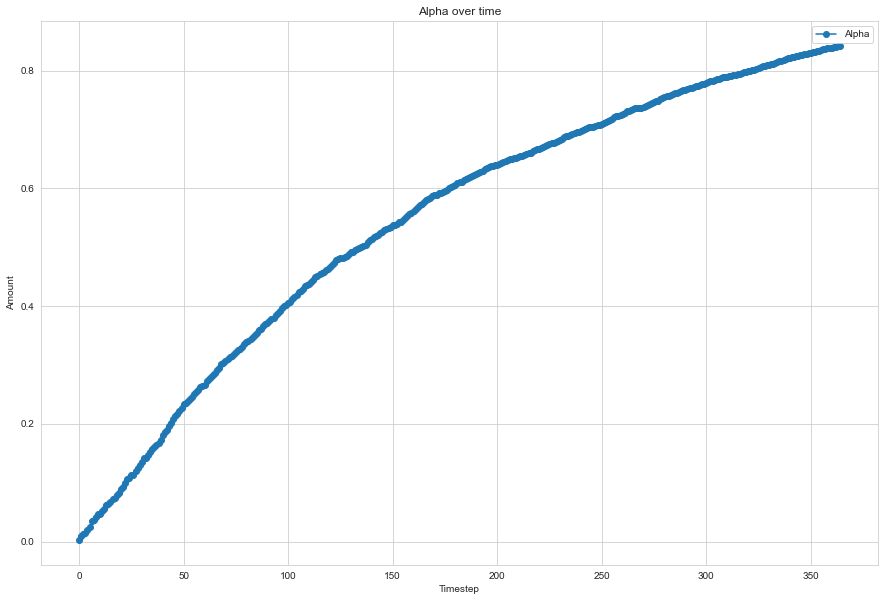

In [25]:
alpha(experiments,'Alpha over time', len(New_Timesteps))

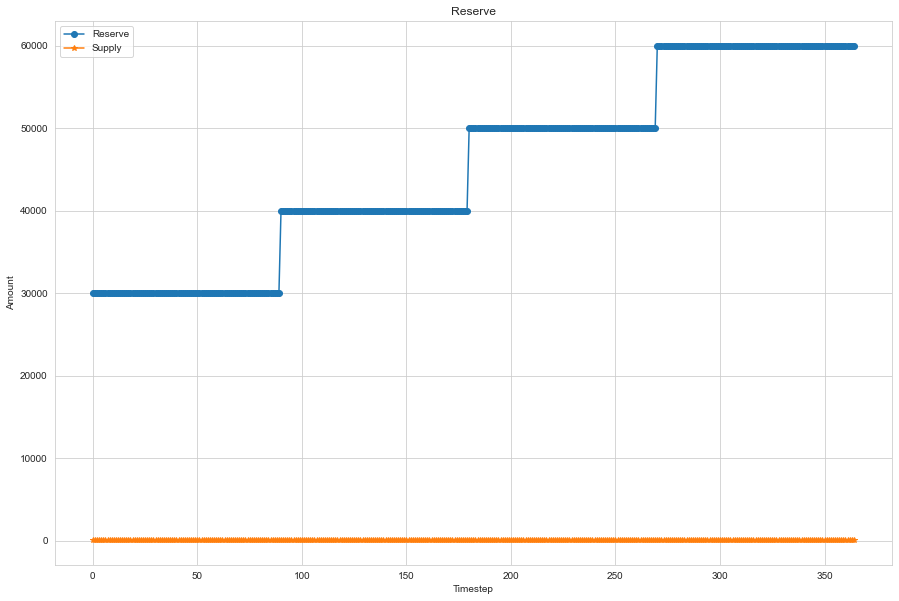

In [26]:
reserve_supply(experiments,'Reserve',len(New_Timesteps))

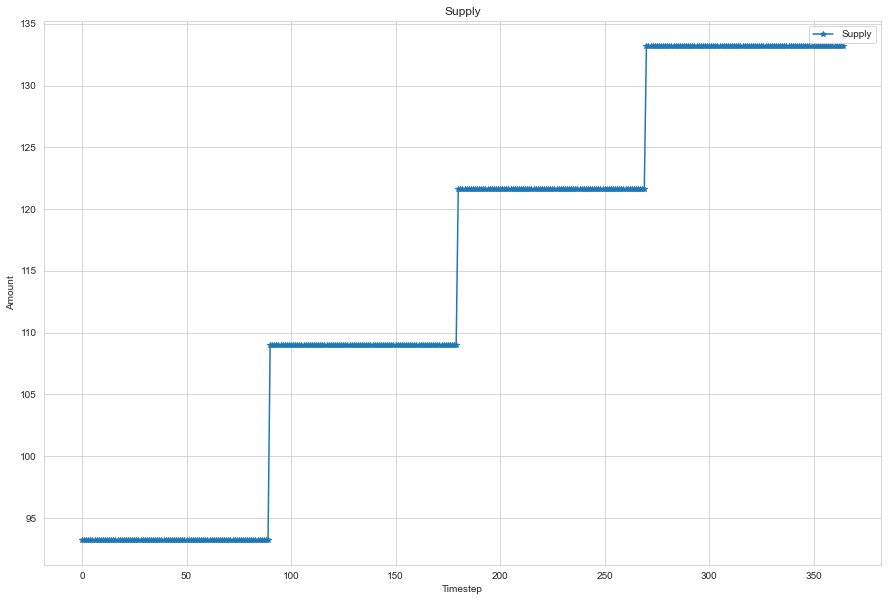

In [27]:
supply_plot(experiments,'Supply',len(New_Timesteps))

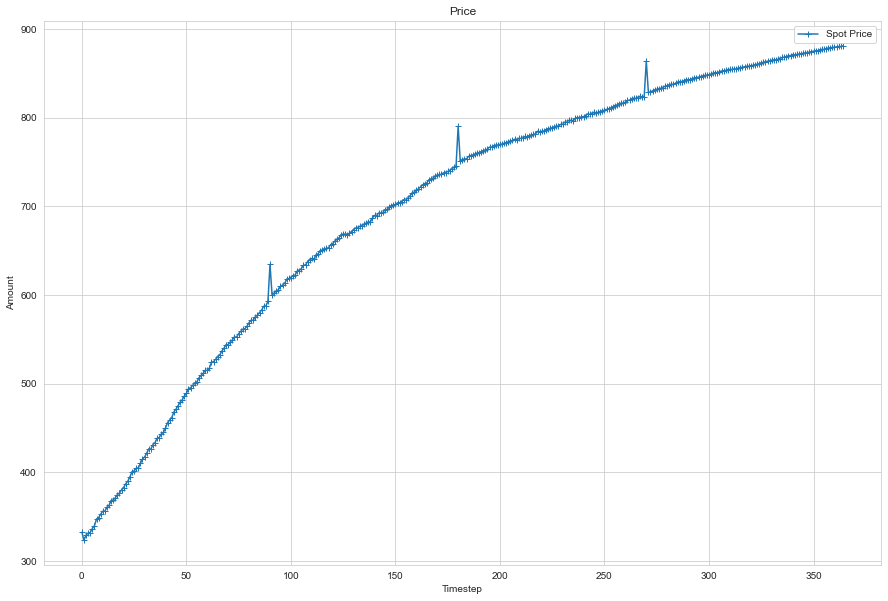

In [28]:
price(experiments,'Price',len(New_Timesteps))

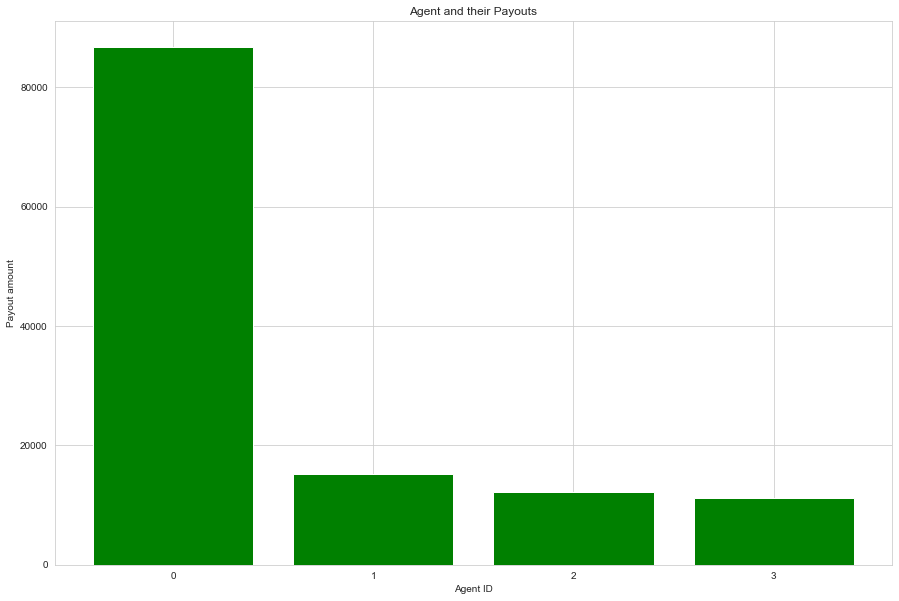

In [29]:
# agent_payout(experiments,len(New_Timesteps))
agent_payout(experiments,1825)

## Conclusion

This notebook demonstrates the simulated behaviour of the risk-adjusted bonding curve with the funding flows as described in the Chimple Pilot use case. We can see, by comparing the results shown above with the initial diagram (copied below for reference) the capital outlay and returns earned by each of the 4 investors in this simulation.  

| Agent | Investment | Return | ROI |
|-------|------------|--------|-----|
| 0 | 30,000 | xx | xx% |
| 1 | 10,000 | xx | xx% |
| 2 | 10,000 | xx | xx% |
| 3 | 10,000 | xx | xx% |

In [30]:


# For displaying image files
# from IPython.display import Image
# Image("images/Chimple_Scenario-4.png")